In [1]:
import numpy as np
from cluster_sim.app.holes import Holes
from cluster_sim.app.grid import Grid
from cluster_sim.app.utils import get_node_coords

import os
from joblib import delayed, Parallel
import time
from analysis_funcs import algorithm1, apply_error_channel, ParallelTqdm
import networkx as nx

os.makedirs("./data", exist_ok=True)

shape = [20, 20, 200]
seed = 12345

samples = 5

# The probabilities to simulate
p_vec = np.linspace(0, 0.3, 20)

# Input vector for all jobs
jobs_input_vec = p_vec

In [2]:
def main(input_params):
    """
    Main function for parallel processing. Here, we:

    1. Create a grid of the given shape
    2. Apply the error channel to the grid
    3. Generate a RHG lattice
    4. Look at clusters of the RHG lattice
    5. Return the results

    Returns:
        - p: The input parameter for the simulation
        - percolates: The number of times percolation occurred (True: 1, False: 0)
        - times: The average time taken for the simulation
    """
    
    p = input_params

    # Sanity check: check that this is equal to the move_list on the app
    # print(np.reshape(np.argwhere(removed_nodes == True), shape=-1))
    
    percolates = 0
    
    times = np.zeros(samples)
    diffs = np.zeros(samples)
    for i in range(samples):
        start = time.time()
        G = Grid(shape)
        removed_nodes = np.zeros(shape[0] * shape[1] * shape[2], dtype=bool)

        G, D, removed_nodes = apply_error_channel(p, seed + i, shape, removed_nodes, G)

        # Generate an RHG lattice out of G
        G, removed_nodes, offsets = algorithm1(G, D, removed_nodes, shape)

        xoffset, yoffset, zoffset = offsets

        cubes, _ = D.find_lattice(removed_nodes, xoffset, yoffset, zoffset)

        C = D.build_centers_graph(cubes)

        largest_cc = max(nx.connected_components(C), key=len)
        largest_cc = C.subgraph(largest_cc).copy()

        # Check if the largest cluster percolates
        low = np.array([np.inf, np.inf, np.inf])
        high = np.zeros(3)

        if not largest_cc:
            #print("No clusters")
            diffs[i] = 0

        else:
            for node in largest_cc.nodes:
                # Get the coordinates of the node
                low = np.minimum(low, np.array(node))
                high = np.maximum(high, np.array(node))
            diffs[i] = high[2] - low[2] 

            #print(f"high = {high}, low={low}, diff={diff}")
            if shape[2] - diffs[i] <= 3:
                percolates += 1

        times[i] = time.time() - start 

    return (p, percolates, diffs.mean(), times.mean())


In [3]:
results = ParallelTqdm(n_jobs=-1)([delayed(main)(x) for x in jobs_input_vec])
results = np.array(results)
print(results)

100%|██████████| 20/20 [00:28<00:00,  1.43s/tasks]

[[0.00000000e+00 5.00000000e+00 1.97000000e+02 5.03293152e+00]
 [1.57894737e-02 5.00000000e+00 1.97000000e+02 4.18765817e+00]
 [3.15789474e-02 5.00000000e+00 1.97000000e+02 3.42737350e+00]
 [4.73684211e-02 5.00000000e+00 1.97000000e+02 2.89729180e+00]
 [6.31578947e-02 5.00000000e+00 1.97000000e+02 2.50092487e+00]
 [7.89473684e-02 4.00000000e+00 1.79800000e+02 2.16988459e+00]
 [9.47368421e-02 0.00000000e+00 6.48000000e+01 1.94423032e+00]
 [1.10526316e-01 0.00000000e+00 2.56000000e+01 1.85870523e+00]
 [1.26315789e-01 0.00000000e+00 1.56000000e+01 1.62100468e+00]
 [1.42105263e-01 0.00000000e+00 1.14000000e+01 1.52795420e+00]
 [1.57894737e-01 0.00000000e+00 8.00000000e+00 1.48966498e+00]
 [1.73684211e-01 0.00000000e+00 5.00000000e+00 1.41908722e+00]
 [1.89473684e-01 0.00000000e+00 4.40000000e+00 1.45288649e+00]
 [2.05263158e-01 0.00000000e+00 3.40000000e+00 1.35424914e+00]
 [2.21052632e-01 0.00000000e+00 2.40000000e+00 1.32364802e+00]
 [2.36842105e-01 0.00000000e+00 2.80000000e+00 1.324782

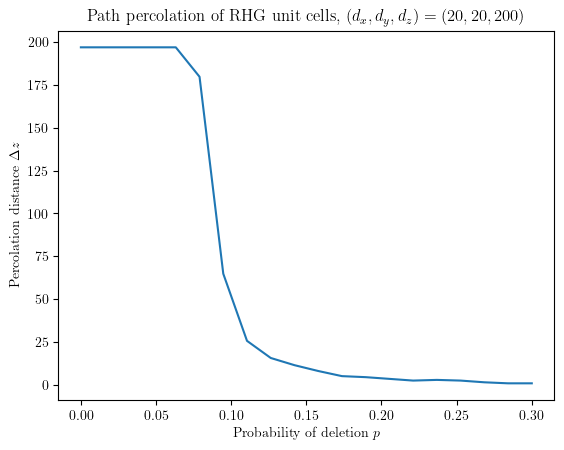

Exception ignored in: <function ResourceTracker.__del__ at 0x1035fe980>
Traceback (most recent call last):
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104792980>
Traceback (most recent call last):
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/zhihan/miniconda3/envs/mbqc/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No 

In [4]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern']    
    })

plt.plot(results[:, 0], results[:, 2])
plt.xlabel(r"Probability of deletion $p$")
plt.ylabel(r"Percolation distance $\Delta z$")
plt.title(r"Path percolation of RHG unit cells, $(d_x, d_y, d_z)=(20, 20, 200)$")
plt.savefig(f"data/path_percolation_rhg_unit_cells{samples}.pdf", dpi=300)